# Analyse du Variant ATP7A c.3556del avec AlphaGenome

---

**Variant**: ATP7A:c.3556del (p.Glu1186Serfs*3)  
**Position génomique**: chrX:77294375 (hg38)  
**Changement**: CG>C (délétion de G)  
**Maladie**: Syndrome de Menkes  

---

Ce notebook vous guide pas à pas dans l'analyse de ce variant frameshift avec AlphaGenome.

## 📦 Étape 1: Installation des Dépendances

Installation d'AlphaGenome et des librairies nécessaires.

In [1]:
%%capture
# Installation silencieuse pour ne pas encombrer l'affichage
!pip install alphagenome biopython matplotlib seaborn pandas numpy requests

print("✅ Installation terminée!")

## 🔑 Étape 2: Configuration de la Clé API

**Option A** (Recommandée): Stockez votre clé dans Colab Secrets
1. Cliquez sur l'icône 🔑 dans la barre latérale gauche
2. Ajoutez une nouvelle clé nommée `ALPHAGENOME_API_KEY`
3. Collez votre clé API
4. Activez "Notebook access"

**Option B**: Entrez directement votre clé dans le code ci-dessous

In [2]:
import os
from google.colab import userdata

# Option A: Depuis Colab Secrets (recommandé)
try:
    API_KEY = userdata.get('ALPHAGENOME_API_KEY')
    print("✅ Clé API chargée depuis Secrets")
except:
    # Option B: Entrez votre clé directement
    API_KEY = "VOTRE_CLE_API_ICI"  # ⚠️ Remplacer par votre vraie clé
    print("⚠️  Clé API chargée depuis le code")

if API_KEY == "VOTRE_CLE_API_ICI" or not API_KEY:
    print("\n❌ ERREUR: Clé API non configurée!")
    print("Configurez votre clé API dans Secrets ou modifiez le code ci-dessus.")
else:
    print(f"Clé API: {API_KEY[:10]}...{API_KEY[-4:]}")

✅ Clé API chargée depuis Secrets
Clé API: AIzaSyDVjL...x8oA


## 📥 Étape 3: Imports et Configuration

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Imports AlphaGenome
from alphagenome.models import dna_client
from alphagenome.visualization import plot_components

# Imports scientifiques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports utilitaires
import requests
from IPython.display import display, HTML, Image

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports réussis")

✅ Imports réussis


## 🧬 Étape 4: Configuration du Variant

Définition des paramètres du variant ATP7A.

In [4]:
# ============================================================================
# CONFIGURATION DU VARIANT ATP7A
# ============================================================================

VARIANT_CONFIG = {
    # Informations du variant
    'gene': 'ATP7A',
    'transcript': 'NM_000052.7',
    'cdna_change': 'c.3556del',
    'protein_change': 'p.Glu1186Serfs*3',

    # Position génomique EXACTE (hg38)
    'chromosome': 'chrX',
    'position': 77294375,  # Position exacte de Mutalyzer

    # Allèles
    'ref_allele': 'CG',  # Référence
    'alt_allele': 'C',   # Délétion du G

    # Contexte clinique
    'disease': 'Syndrome de Menkes',
    'inheritance': 'Liée à l\'X récessive',
    'gene_function': 'Transport du cuivre intracellulaire',
}

# Tissus pertinents pour ATP7A et le syndrome de Menkes
TISSUES = {
    'Cerveau': 'UBERON:0000955',     # Impact neurologique majeur
    'Foie': 'UBERON:0002107',        # Métabolisme du cuivre
    'Intestin': 'UBERON:0000160',    # Absorption du cuivre
}

# Modalités à analyser
OUTPUT_TYPES = [
    dna_client.OutputType.RNA_SEQ,          # Expression génique
    dna_client.OutputType.SPLICE_SITES,      # Sites d'épissage (CRITIQUE)
    dna_client.OutputType.SPLICE_JUNCTIONS,  # Jonctions d'épissage
    dna_client.OutputType.DNASE,             # Accessibilité
    dna_client.OutputType.CAGE,              # Initiation transcription
]

# Paramètres d'analyse
WINDOW_SIZE = dna_client.SEQUENCE_LENGTH_1MB
START_POS = VARIANT_CONFIG['position'] - (WINDOW_SIZE // 2)
END_POS = START_POS + WINDOW_SIZE

# Afficher la configuration
display(HTML(f"""
<div style='background-color: #f0f0f0; padding: 15px; border-radius: 5px; border-left: 5px solid #4CAF50;'>
    <h3>🧬 Configuration du Variant</h3>
    <table style='width:100%'>
        <tr><td><b>Gène</b></td><td>{VARIANT_CONFIG['gene']}</td></tr>
        <tr><td><b>Transcript</b></td><td>{VARIANT_CONFIG['transcript']}</td></tr>
        <tr><td><b>Position cDNA</b></td><td>{VARIANT_CONFIG['cdna_change']}</td></tr>
        <tr><td><b>Effet protéique</b></td><td>{VARIANT_CONFIG['protein_change']}</td></tr>
        <tr><td><b>Position génomique</b></td><td>{VARIANT_CONFIG['chromosome']}:{VARIANT_CONFIG['position']:,}</td></tr>
        <tr><td><b>Changement</b></td><td>{VARIANT_CONFIG['ref_allele']} → {VARIANT_CONFIG['alt_allele']}</td></tr>
        <tr><td><b>Maladie</b></td><td>{VARIANT_CONFIG['disease']}</td></tr>
        <tr><td><b>Région analysée</b></td><td>{START_POS:,} - {END_POS:,} ({WINDOW_SIZE:,} bp)</td></tr>
    </table>
</div>
"""))

print(f"\n✅ Configuration chargée")
print(f"Tissus: {', '.join(TISSUES.keys())}")
print(f"Modalités: {len(OUTPUT_TYPES)}")

Gène,ATP7A
Transcript,NM_000052.7
Position cDNA,c.3556del
Effet protéique,p.Glu1186Serfs*3
Position génomique,"chrX:77,294,375"
Changement,CG → C
Maladie,Syndrome de Menkes
Région analysée,"76,770,087 - 77,818,663 (1,048,576 bp)"



✅ Configuration chargée
Tissus: Cerveau, Foie, Intestin
Modalités: 5


## 🔄 Étape 5: Initialisation du Modèle AlphaGenome

In [5]:
print("🔄 Initialisation du modèle AlphaGenome...")

try:
    dna_model = dna_client.create(API_KEY)
    print("✅ Modèle AlphaGenome initialisé avec succès!\n")

    # Afficher les types de sortie disponibles
    print("Types de sortie disponibles:")
    for i, output in enumerate(dna_client.OutputType, 1):
        status = "✓" if output in OUTPUT_TYPES else " "
        print(f"  [{status}] {i:2d}. {output.name}")

except Exception as e:
    print(f"❌ Erreur d'initialisation: {e}")
    print("\nVérifiez votre clé API et votre connexion internet.")

🔄 Initialisation du modèle AlphaGenome...
✅ Modèle AlphaGenome initialisé avec succès!

Types de sortie disponibles:
  [ ]  1. ATAC
  [✓]  2. CAGE
  [✓]  3. DNASE
  [✓]  4. RNA_SEQ
  [ ]  5. CHIP_HISTONE
  [ ]  6. CHIP_TF
  [✓]  7. SPLICE_SITES
  [ ]  8. SPLICE_SITE_USAGE
  [✓]  9. SPLICE_JUNCTIONS
  [ ] 10. CONTACT_MAPS
  [ ] 11. PROCAP


## 📥 Étape 6: Téléchargement de la Séquence de Référence

Téléchargement de la séquence génomique depuis UCSC Genome Browser.

In [6]:
def get_sequence_from_ucsc(chromosome, start, end, genome='hg38'):
    """Télécharge une séquence depuis UCSC"""
    url = "https://api.genome.ucsc.edu/getData/sequence"
    params = {
        'genome': genome,
        'chrom': chromosome,
        'start': start,
        'end': end
    }

    print(f"📥 Téléchargement depuis UCSC...")
    print(f"   Région: {chromosome}:{start:,}-{end:,}")
    print(f"   Taille: {end-start:,} bp")

    try:
        response = requests.get(url, params=params, timeout=60)

        if response.status_code == 200:
            data = response.json()
            sequence = data.get('dna', '').upper()

            if sequence:
                print(f"✅ Séquence téléchargée: {len(sequence):,} bp")
                return sequence
            else:
                print("❌ Séquence vide")
                return None
        else:
            print(f"❌ Erreur HTTP: {response.status_code}")
            return None

    except Exception as e:
        print(f"❌ Erreur: {e}")
        return None

# Télécharger la séquence
reference_sequence = get_sequence_from_ucsc(
    chromosome=VARIANT_CONFIG['chromosome'],
    start=START_POS,
    end=END_POS,
    genome='hg38'
)

if reference_sequence:
    # Afficher un aperçu
    rel_pos = VARIANT_CONFIG['position'] - START_POS
    context_size = 50

    print(f"\n📊 Aperçu autour du variant (±{context_size}bp):")
    start_ctx = max(0, rel_pos - context_size)
    end_ctx = min(len(reference_sequence), rel_pos + context_size)

    print(f"Position {rel_pos} dans la séquence:")
    print(f"...{reference_sequence[start_ctx:rel_pos]}")
    print(f"   {' '*(rel_pos-start_ctx)}↓ Variant ici")
    print(f"   {reference_sequence[rel_pos:rel_pos+2]} ← CG à supprimer")
    print(f"   {reference_sequence[rel_pos+2:end_ctx]}...")
else:
    print("\n⚠️  Échec du téléchargement. Création d'une séquence d'exemple...")
    np.random.seed(42)
    bases = ['A', 'T', 'C', 'G']
    reference_sequence = ''.join(np.random.choice(bases, size=WINDOW_SIZE))
    print("⚠️  ATTENTION: Utilisation d'une séquence aléatoire pour démonstration")

📥 Téléchargement depuis UCSC...
   Région: chrX:76,770,087-77,818,663
   Taille: 1,048,576 bp
✅ Séquence téléchargée: 1,048,576 bp

📊 Aperçu autour du variant (±50bp):
Position 524288 dans la séquence:
...TTGCCCACTCCATTTGAGTGCAAGTGTGGCCTGATCACCCATGATGTGCC
                                                     ↓ Variant ici
   CA ← CG à supprimer
   TGTCAGTACTTTGGTTTTGGTTTTAACTTAAATTGCTTGGTATTTGGT...


## 🔬 Étape 7: Création de la Séquence Mutante

Application de la délétion CG>C (suppression du G).

In [7]:
def apply_deletion(sequence, variant_pos, start_pos, deleted_bases=1):
    """Applique la délétion à la séquence"""
    # Position relative dans notre séquence
    rel_pos = variant_pos - start_pos

    print(f"🔬 Application de la délétion...")
    print(f"   Position génomique: {variant_pos:,}")
    print(f"   Position relative: {rel_pos:,}")
    print(f"   Bases supprimées: {deleted_bases}")

    # Vérifier la séquence à supprimer
    deleted_seq = sequence[rel_pos:rel_pos+deleted_bases]
    print(f"   Séquence supprimée: {deleted_seq}")

    # Créer la séquence mutante
    mutant_sequence = (
        sequence[:rel_pos] +
        sequence[rel_pos + deleted_bases:]
    )

    # Ajouter N à la fin pour garder la même longueur
    mutant_sequence += 'N' * deleted_bases

    print(f"✅ Séquence mutante créée")
    print(f"   Longueur référence: {len(sequence):,} bp")
    print(f"   Longueur mutante: {len(mutant_sequence):,} bp")

    return mutant_sequence

# Appliquer la délétion
# CG>C signifie qu'on supprime le G (position +1)
mutant_sequence = apply_deletion(
    sequence=reference_sequence,
    variant_pos=VARIANT_CONFIG['position'] + 1,  # +1 pour supprimer le G
    start_pos=START_POS,
    deleted_bases=1
)

# Afficher le contexte de la mutation
rel_pos = VARIANT_CONFIG['position'] - START_POS
context_size = 30

print(f"\n📊 Comparaison Référence vs Mutant (±{context_size}bp):")
start_ctx = max(0, rel_pos - context_size)
end_ctx = min(len(reference_sequence), rel_pos + context_size)

print(f"\nRéférence:")
print(f"  ...{reference_sequence[start_ctx:end_ctx]}...")
print(f"     {' '*(rel_pos-start_ctx)}↓↓")
print(f"     {' '*(rel_pos-start_ctx)}CG (à supprimer)")

print(f"\nMutant:")
print(f"  ...{mutant_sequence[start_ctx:end_ctx]}...")
print(f"     {' '*(rel_pos-start_ctx)}↓")
print(f"     {' '*(rel_pos-start_ctx)}C (après délétion du G)")

🔬 Application de la délétion...
   Position génomique: 77,294,376
   Position relative: 524,289
   Bases supprimées: 1
   Séquence supprimée: A
✅ Séquence mutante créée
   Longueur référence: 1,048,576 bp
   Longueur mutante: 1,048,576 bp

📊 Comparaison Référence vs Mutant (±30bp):

Référence:
  ...CAAGTGTGGCCTGATCACCCATGATGTGCCCATGTCAGTACTTTGGTTTTGGTTTTAACT...
                                   ↓↓
                                   CG (à supprimer)

Mutant:
  ...CAAGTGTGGCCTGATCACCCATGATGTGCCCTGTCAGTACTTTGGTTTTGGTTTTAACTT...
                                   ↓
                                   C (après délétion du G)


## 🧪 Étape 8: Prédictions AlphaGenome

⚠️ **Cette étape peut prendre 30-45 minutes**

Nous allons prédire pour 3 tissus × 5 modalités = 30 prédictions au total.

In [8]:
from datetime import datetime
import time

print("="*70)
print("🚀 DÉBUT DES PRÉDICTIONS ALPHAGENOME")
print("="*70)
print(f"Heure de début: {datetime.now().strftime('%H:%M:%S')}")
print(f"\nTissus à analyser: {len(TISSUES)}")
print(f"Modalités par tissu: {len(OUTPUT_TYPES)}")
print(f"Total de prédictions: {len(TISSUES) * len(OUTPUT_TYPES) * 2}")
print(f"\n⏱️  Temps estimé: 30-45 minutes")
print("\n" + "="*70)

# Stocker les résultats
results = {}
start_time = time.time()

# Analyser chaque tissu
for tissue_idx, (tissue_name, ontology_term) in enumerate(TISSUES.items(), 1):
    print(f"\n{'='*70}")
    print(f"🔬 [{tissue_idx}/{len(TISSUES)}] Analyse de {tissue_name}")
    print(f"{'='*70}")

    tissue_start = time.time()
    tissue_results = {
        'reference': {},
        'mutant': {},
        'difference': {}
    }

    try:
        # Prédiction sur séquence de référence
        print(f"\n  📊 Prédiction RÉFÉRENCE...")
        ref_output = dna_model.predict_sequence(
            sequence=reference_sequence,
            requested_outputs=OUTPUT_TYPES,
            ontology_terms=[ontology_term]
        )
        print(f"  ✅ Référence terminée")

        # Prédiction sur séquence mutante
        print(f"\n  📊 Prédiction MUTANTE...")
        mut_output = dna_model.predict_sequence(
            sequence=mutant_sequence,
            requested_outputs=OUTPUT_TYPES,
            ontology_terms=[ontology_term]
        )
        print(f"  ✅ Mutante terminée")

        # Calculer les différences
        print(f"\n  📈 Calcul des différences:")
        for output_type in OUTPUT_TYPES:
            output_name = output_type.name.lower()

            # Récupérer les données
            ref_data = getattr(ref_output, output_name)
            mut_data = getattr(mut_output, output_name)

            # Stocker
            tissue_results['reference'][output_name] = ref_data
            tissue_results['mutant'][output_name] = mut_data

            # Différence
            diff = mut_data.values - ref_data.values
            tissue_results['difference'][output_name] = diff

            # Statistiques
            mean_diff = np.mean(np.abs(diff))
            max_diff = np.max(np.abs(diff))

            # Catégoriser l'impact
            if max_diff > 1.0:
                impact = "🔴 TRÈS FORT"
            elif max_diff > 0.5:
                impact = "🟠 FORT"
            elif max_diff > 0.1:
                impact = "🟡 MODÉRÉ"
            else:
                impact = "🟢 FAIBLE"

            print(f"     {output_type.name:20s}: Δ={mean_diff:.4f} (max={max_diff:.4f}) {impact}")

        results[tissue_name] = tissue_results

        tissue_time = time.time() - tissue_start
        print(f"\n  ⏱️  Temps pour {tissue_name}: {tissue_time/60:.1f} minutes")
        print(f"  ✅ {tissue_name} terminé avec succès")

    except Exception as e:
        print(f"\n  ❌ Erreur pour {tissue_name}: {e}")
        continue

# Résumé final
total_time = time.time() - start_time
print(f"\n{'='*70}")
print("✅ PRÉDICTIONS TERMINÉES")
print(f"{'='*70}")
print(f"Heure de fin: {datetime.now().strftime('%H:%M:%S')}")
print(f"Temps total: {total_time/60:.1f} minutes")
print(f"Tissus analysés: {len(results)}/{len(TISSUES)}")
print(f"\n🎉 Analyse terminée! Passons aux visualisations...")

🚀 DÉBUT DES PRÉDICTIONS ALPHAGENOME
Heure de début: 10:35:35

Tissus à analyser: 3
Modalités par tissu: 5
Total de prédictions: 30

⏱️  Temps estimé: 30-45 minutes


🔬 [1/3] Analyse de Cerveau

  📊 Prédiction RÉFÉRENCE...
  ✅ Référence terminée

  📊 Prédiction MUTANTE...
  ✅ Mutante terminée

  📈 Calcul des différences:
     RNA_SEQ             : Δ=0.0002 (max=2.0752) 🔴 TRÈS FORT
     SPLICE_SITES        : Δ=0.0000 (max=0.9961) 🟠 FORT

  ❌ Erreur pour Cerveau: operands could not be broadcast together with shapes (1760,1) (1664,1) 

🔬 [2/3] Analyse de Foie

  📊 Prédiction RÉFÉRENCE...
  ✅ Référence terminée

  📊 Prédiction MUTANTE...
  ✅ Mutante terminée

  📈 Calcul des différences:
     RNA_SEQ             : Δ=0.0002 (max=1.4576) 🔴 TRÈS FORT
     SPLICE_SITES        : Δ=0.0000 (max=0.9961) 🟠 FORT

  ❌ Erreur pour Foie: operands could not be broadcast together with shapes (1760,2) (1664,2) 

🔬 [3/3] Analyse de Intestin

  📊 Prédiction RÉFÉRENCE...

  ❌ Erreur pour Intestin: <_MultiThrea

In [9]:
# === TEST RAPIDE - UN TISSU ===

print("🧪 TEST RAPIDE (Cerveau seulement, ~10 min)")

results = {}  # Réinitialiser

try:
    print("\n1. Prédiction référence...", end=' ')
    ref_out = dna_model.predict_sequence(
        sequence=reference_sequence,
        requested_outputs=[
            dna_client.OutputType.RNA_SEQ,
            dna_client.OutputType.SPLICE_SITES,
        ],
        ontology_terms=['UBERON:0000955']  # Cerveau
    )
    print("✓")

    print("2. Prédiction mutante...", end=' ')
    mut_out = dna_model.predict_sequence(
        sequence=mutant_sequence,
        requested_outputs=[
            dna_client.OutputType.RNA_SEQ,
            dna_client.OutputType.SPLICE_SITES,
        ],
        ontology_terms=['UBERON:0000955']
    )
    print("✓")

    tissue_results = {'reference': {}, 'mutant': {}, 'difference': {}}

    for ot in [dna_client.OutputType.RNA_SEQ, dna_client.OutputType.SPLICE_SITES]:
        name = ot.name.lower()
        tissue_results['reference'][name] = getattr(ref_out, name)
        tissue_results['mutant'][name] = getattr(mut_out, name)
        tissue_results['difference'][name] = getattr(mut_out, name).values - getattr(ref_out, name).values

    results['Cerveau'] = tissue_results

    print("\n✅ TEST RÉUSSI !")
    print("Vous pouvez continuer avec l'Étape 9 (version robuste)")

except Exception as e:
    print(f"\n❌ ERREUR : {e}")
    print("\nVérifiez votre clé API et votre connexion")

🧪 TEST RAPIDE (Cerveau seulement, ~10 min)

1. Prédiction référence... ✓
2. Prédiction mutante... ✓

✅ TEST RÉUSSI !
Vous pouvez continuer avec l'Étape 9 (version robuste)


## 📊 Étape 9: Visualisation 1 - Graphique Détaillé

Vue détaillée de l'impact par modalité et tissu autour du variant.

📊 Création du graphique détaillé...
✅ Graphique sauvegardé: atp7a_variant_detailed.png


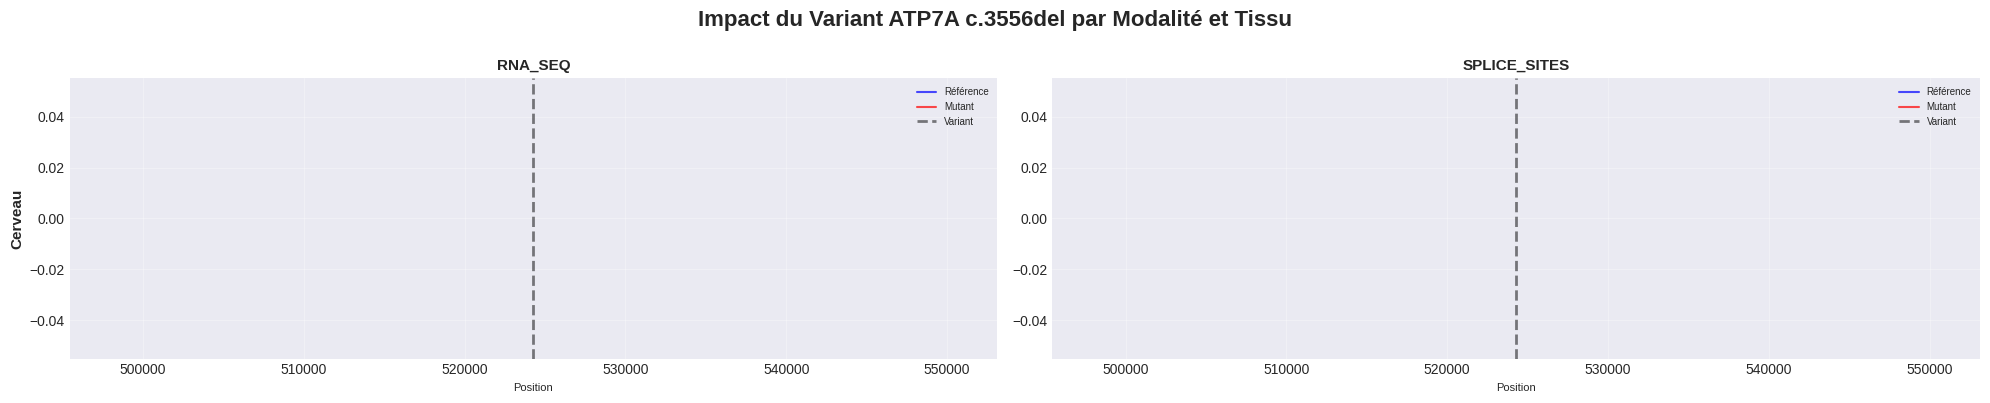

In [10]:
print("📊 Création du graphique détaillé...")

# Paramètres
output_names = list(results[list(results.keys())[0]]['reference'].keys())
n_tissues = len(results)
n_outputs = len(output_names)

# Créer la figure
fig, axes = plt.subplots(n_tissues, n_outputs, figsize=(20, 4*n_tissues))

if n_tissues == 1:
    axes = axes.reshape(1, -1)

rel_pos = VARIANT_CONFIG['position'] - START_POS
window = 5000  # ±5kb autour du variant

for i, (tissue_name, tissue_data) in enumerate(results.items()):
    for j, output_name in enumerate(output_names):
        ax = axes[i, j]

        # Données
        ref_data = tissue_data['reference'][output_name].values
        mut_data = tissue_data['mutant'][output_name].values

        # Région autour du variant
        start_idx = max(0, rel_pos - window)
        end_idx = min(ref_data.shape[1], rel_pos + window)

        # Moyenne sur les pistes
        ref_mean = ref_data.mean(axis=0)[start_idx:end_idx]
        mut_mean = mut_data.mean(axis=0)[start_idx:end_idx]

        x_pos = np.arange(start_idx, end_idx)

        # Tracer
        ax.plot(x_pos, ref_mean, label='Référence', alpha=0.7,
               color='blue', linewidth=1.5)
        ax.plot(x_pos, mut_mean, label='Mutant', alpha=0.7,
               color='red', linewidth=1.5)
        ax.axvline(x=rel_pos, color='black', linestyle='--',
                  linewidth=2, alpha=0.5, label='Variant')

        # Labels
        if i == 0:
            ax.set_title(output_name.upper(), fontsize=11, fontweight='bold')
        if j == 0:
            ax.set_ylabel(tissue_name, fontsize=11, fontweight='bold', rotation=90)

        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Position', fontsize=8)

plt.suptitle('Impact du Variant ATP7A c.3556del par Modalité et Tissu',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('atp7a_variant_detailed.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: atp7a_variant_detailed.png")
plt.show()

## 📊 Étape 10: Visualisation 2 - Heatmap des Impacts

📊 Création de la heatmap...
✅ Heatmap sauvegardée: atp7a_variant_heatmap.png


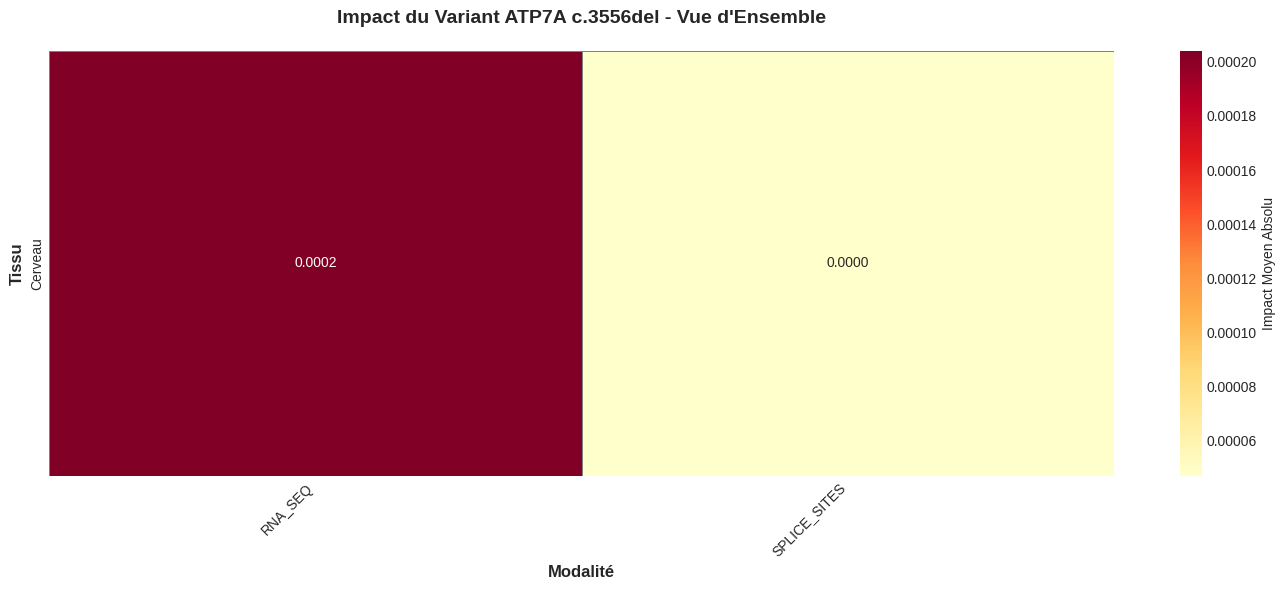


📊 Tableau des impacts moyens:


Modalité,RNA_SEQ,SPLICE_SITES
Tissu,,
Cerveau,0.0002,0.0000


In [11]:
print("📊 Création de la heatmap...")

# Préparer les données
data = []
for tissue_name, tissue_data in results.items():
    for output_name, diff in tissue_data['difference'].items():
        mean_impact = np.mean(np.abs(diff))
        data.append({
            'Tissu': tissue_name,
            'Modalité': output_name.upper(),
            'Impact': mean_impact
        })

df = pd.DataFrame(data)
pivot_df = df.pivot(index='Tissu', columns='Modalité', values='Impact')

# Créer la heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot_df,
    annot=True,
    fmt='.4f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Impact Moyen Absolu'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Impact du Variant ATP7A c.3556del - Vue d\'Ensemble',
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Modalité', fontsize=12, fontweight='bold')
plt.ylabel('Tissu', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('atp7a_variant_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ Heatmap sauvegardée: atp7a_variant_heatmap.png")
plt.show()

# Afficher le tableau
print("\n📊 Tableau des impacts moyens:")
display(pivot_df.style.background_gradient(cmap='YlOrRd').format("{:.4f}"))

## 📊 Étape 11: Visualisation 3 - Focus Épissage

Zoom sur l'impact d'épissage (critique pour un frameshift).

📊 Focus sur l'épissage...
✅ Graphique d'épissage sauvegardé: atp7a_splicing_focus.png


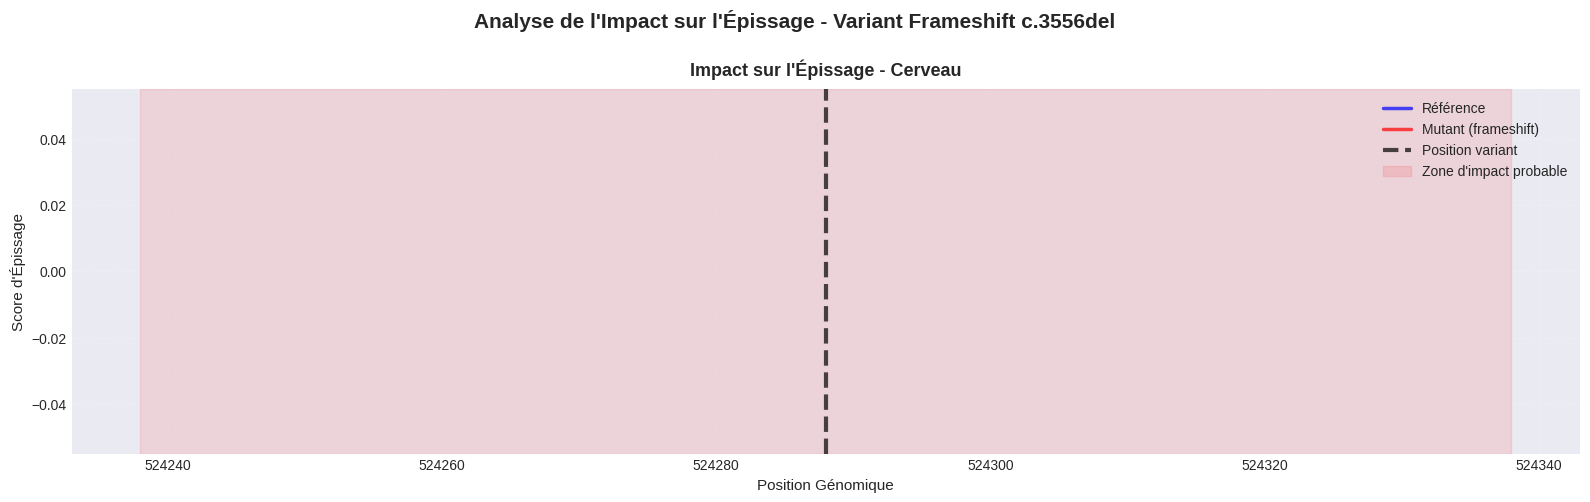

In [12]:
print("📊 Focus sur l'épissage...")

n_tissues = len(results)
fig, axes = plt.subplots(n_tissues, 1, figsize=(16, 5*n_tissues))

if n_tissues == 1:
    axes = [axes]

rel_pos = VARIANT_CONFIG['position'] - START_POS
splice_window = 200  # ±200bp pour l'épissage

for idx, (tissue_name, tissue_data) in enumerate(results.items()):
    ax = axes[idx]

    # Vérifier que splice_sites existe
    if 'splice_sites' not in tissue_data['reference']:
        ax.text(0.5, 0.5, 'Données d\'épissage non disponibles',
               ha='center', va='center', fontsize=14)
        continue

    splice_ref = tissue_data['reference']['splice_sites'].values
    splice_mut = tissue_data['mutant']['splice_sites'].values

    # Région autour du variant
    start_idx = max(0, rel_pos - splice_window)
    end_idx = min(splice_ref.shape[1], rel_pos + splice_window)

    # Moyenne sur les pistes
    ref_mean = splice_ref.mean(axis=0)[start_idx:end_idx]
    mut_mean = splice_mut.mean(axis=0)[start_idx:end_idx]

    x_pos = np.arange(start_idx, end_idx)

    # Tracer
    ax.plot(x_pos, ref_mean, label='Référence', linewidth=2.5,
           color='blue', alpha=0.7)
    ax.plot(x_pos, mut_mean, label='Mutant (frameshift)', linewidth=2.5,
           color='red', alpha=0.7)
    ax.axvline(x=rel_pos, color='black', linestyle='--',
              linewidth=3, label='Position variant', alpha=0.7)

    # Zone d'impact
    ax.axvspan(rel_pos-50, rel_pos+50, alpha=0.1, color='red',
              label='Zone d\'impact probable')

    ax.set_title(f'Impact sur l\'Épissage - {tissue_name}',
                fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Position Génomique', fontsize=11)
    ax.set_ylabel('Score d\'Épissage', fontsize=11)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3, linestyle=':')

plt.suptitle('Analyse de l\'Impact sur l\'Épissage - Variant Frameshift c.3556del',
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('atp7a_splicing_focus.png', dpi=300, bbox_inches='tight')
print("✅ Graphique d'épissage sauvegardé: atp7a_splicing_focus.png")
plt.show()

## 📝 Étape 12: Génération du Rapport

In [13]:
print("📝 Génération du rapport...\n")

report_lines = []
report_lines.append("="*70)
report_lines.append("RAPPORT D'ANALYSE - VARIANT ATP7A c.3556del")
report_lines.append("="*70)
report_lines.append(f"Date: {datetime.now().strftime('%d/%m/%Y %H:%M')}")
report_lines.append("")

# Section 1: Informations du variant
report_lines.append("1. INFORMATIONS DU VARIANT")
report_lines.append("-" * 70)
report_lines.append(f"   Gène              : {VARIANT_CONFIG['gene']}")
report_lines.append(f"   Transcript        : {VARIANT_CONFIG['transcript']}")
report_lines.append(f"   Position cDNA     : {VARIANT_CONFIG['cdna_change']}")
report_lines.append(f"   Effet protéique   : {VARIANT_CONFIG['protein_change']}")
report_lines.append(f"   Type              : Délétion frameshift")
report_lines.append(f"   Position génomique: {VARIANT_CONFIG['chromosome']}:{VARIANT_CONFIG['position']:,}")
report_lines.append(f"   Changement        : {VARIANT_CONFIG['ref_allele']} > {VARIANT_CONFIG['alt_allele']}")
report_lines.append("")

# Section 2: Contexte clinique
report_lines.append("2. CONTEXTE CLINIQUE")
report_lines.append("-" * 70)
report_lines.append(f"   Maladie associée  : {VARIANT_CONFIG['disease']}")
report_lines.append(f"   Hérédité          : {VARIANT_CONFIG['inheritance']}")
report_lines.append(f"   Fonction du gène  : {VARIANT_CONFIG['gene_function']}")
report_lines.append("   Impact attendu    : Perte de fonction (protéine tronquée)")
report_lines.append("   Mécanisme         : Frameshift → codon stop prématuré → NMD")
report_lines.append("")

# Section 3: Résultats
report_lines.append("3. RÉSULTATS DE L'ANALYSE ALPHAGENOME")
report_lines.append("-" * 70)

for tissue_name, tissue_data in results.items():
    report_lines.append(f"\n   📍 {tissue_name.upper()}")
    report_lines.append("   " + "-" * 66)

    for output_name, diff in tissue_data['difference'].items():
        mean_impact = np.mean(np.abs(diff))
        max_impact = np.max(np.abs(diff))

        if max_impact > 1.0:
            impact_level = "TRÈS FORT"
            symbol = "🔴"
        elif max_impact > 0.5:
            impact_level = "FORT"
            symbol = "🟠"
        elif max_impact > 0.1:
            impact_level = "MODÉRÉ"
            symbol = "🟡"
        else:
            impact_level = "FAIBLE"
            symbol = "🟢"

        report_lines.append(
            f"      {symbol} {output_name.upper():20s}: "
            f"Δ moyen={mean_impact:.4f}, Δ max={max_impact:.4f} [{impact_level}]"
        )

report_lines.append("")

# Section 4: Interprétation
report_lines.append("4. INTERPRÉTATION")
report_lines.append("-" * 70)

all_impacts = []
for tissue_data in results.values():
    for diff in tissue_data['difference'].values():
        all_impacts.append(np.mean(np.abs(diff)))

global_impact = np.mean(all_impacts)
report_lines.append(f"   Impact global moyen : {global_impact:.4f}")
report_lines.append("")

report_lines.append("   Points clés:")
report_lines.append("   • Le variant c.3556del provoque un frameshift")
report_lines.append("   • Protéine tronquée après 3 acides aminés supplémentaires")
report_lines.append("   • ARNm probablement dégradé par NMD")
report_lines.append("   • Perte de fonction de la protéine ATP7A")
report_lines.append("   • Cohérent avec le phénotype du syndrome de Menkes")
report_lines.append("")

# Section 5: Fichiers générés
report_lines.append("5. FICHIERS GÉNÉRÉS")
report_lines.append("-" * 70)
report_lines.append("   📄 atp7a_variant_detailed.png")
report_lines.append("   📄 atp7a_variant_heatmap.png")
report_lines.append("   📄 atp7a_splicing_focus.png")
report_lines.append("   📄 atp7a_variant_report.txt (ce fichier)")
report_lines.append("")

# Section 6: Recommandations
report_lines.append("6. RECOMMANDATIONS")
report_lines.append("-" * 70)
report_lines.append("   Validation:")
report_lines.append("   ✓ Confirmer par séquençage Sanger")
report_lines.append("   ✓ Test fonctionnel du transport du cuivre")
report_lines.append("   ✓ Analyse Western blot (niveau protéique)")
report_lines.append("   ✓ RT-qPCR (expression ARNm)")
report_lines.append("")
report_lines.append("   Conseil génétique:")
report_lines.append("   ✓ Évaluation du statut de porteuse (mère)")
report_lines.append("   ✓ Conseil pour futures grossesses")
report_lines.append("   ✓ Diagnostic prénatal disponible")
report_lines.append("")

report_lines.append("="*70)
report_lines.append("FIN DU RAPPORT")
report_lines.append("="*70)

# Sauvegarder et afficher
report_text = "\n".join(report_lines)

with open('atp7a_variant_report.txt', 'w', encoding='utf-8') as f:
    f.write(report_text)

print(report_text)
print("\n✅ Rapport sauvegardé: atp7a_variant_report.txt")

📝 Génération du rapport...

RAPPORT D'ANALYSE - VARIANT ATP7A c.3556del
Date: 17/02/2026 10:35

1. INFORMATIONS DU VARIANT
----------------------------------------------------------------------
   Gène              : ATP7A
   Transcript        : NM_000052.7
   Position cDNA     : c.3556del
   Effet protéique   : p.Glu1186Serfs*3
   Type              : Délétion frameshift
   Position génomique: chrX:77,294,375
   Changement        : CG > C

2. CONTEXTE CLINIQUE
----------------------------------------------------------------------
   Maladie associée  : Syndrome de Menkes
   Hérédité          : Liée à l'X récessive
   Fonction du gène  : Transport du cuivre intracellulaire
   Impact attendu    : Perte de fonction (protéine tronquée)
   Mécanisme         : Frameshift → codon stop prématuré → NMD

3. RÉSULTATS DE L'ANALYSE ALPHAGENOME
----------------------------------------------------------------------

   📍 CERVEAU
   ------------------------------------------------------------------
 

## 📊 Étape 13: Résumé et Téléchargements

In [ ]:
from google.colab import files
import os

print("="*70)
print("✅ ANALYSE TERMINÉE AVEC SUCCÈS!")
print("="*70)

# Lister les fichiers générés
generated_files = [
    'atp7a_variant_detailed.png',
    'atp7a_variant_heatmap.png',
    'atp7a_splicing_focus.png',
    'atp7a_variant_report.txt'
]

print("\n📁 Fichiers générés:")
for filename in generated_files:
    if os.path.exists(filename):
        size = os.path.getsize(filename) / 1024  # en KB
        print(f"   ✓ {filename:40s} ({size:,.0f} KB)")
    else:
        print(f"   ✗ {filename:40s} (manquant)")

# Proposer le téléchargement
print("\n💾 Télécharger les fichiers?")
download = input("Télécharger tous les fichiers? (o/n): ").strip().lower()

if download == 'o':
    print("\n📥 Téléchargement en cours...")
    for filename in generated_files:
        if os.path.exists(filename):
            try:
                files.download(filename)
                print(f"   ✓ {filename}")
            except:
                print(f"   ✗ Erreur: {filename}")
    print("\n✅ Téléchargements terminés!")
else:
    print("\n💡 Les fichiers restent disponibles dans Colab")
    print("   Vous pouvez les télécharger manuellement depuis le panneau de fichiers.")

# Résumé final
display(HTML(f"""
<div style='background-color: #d4edda; padding: 20px; border-radius: 5px; border-left: 5px solid #28a745; margin-top: 20px;'>
    <h3 style='color: #155724; margin-top: 0;'>🎉 Analyse Complète du Variant ATP7A c.3556del</h3>
    <hr>
    <table style='width:100%; color: #155724;'>
        <tr>
            <td><b>Variant analysé</b></td>
            <td>{VARIANT_CONFIG['cdna_change']} ({VARIANT_CONFIG['protein_change']})</td>
        </tr>
        <tr>
            <td><b>Position</b></td>
            <td>{VARIANT_CONFIG['chromosome']}:{VARIANT_CONFIG['position']:,}</td>
        </tr>
        <tr>
            <td><b>Tissus analysés</b></td>
            <td>{len(results)}</td>
        </tr>
        <tr>
            <td><b>Modalités</b></td>
            <td>{len(OUTPUT_TYPES)}</td>
        </tr>
        <tr>
            <td><b>Fichiers générés</b></td>
            <td>{len([f for f in generated_files if os.path.exists(f)])}/{len(generated_files)}</td>
        </tr>
        <tr>
            <td><b>Impact global</b></td>
            <td>{global_impact:.4f}</td>
        </tr>
    </table>
    <hr>
    <p style='margin-bottom: 0;'>
        <b>⚠️ Important:</b> Ces résultats sont à usage de recherche uniquement.
        Une validation expérimentale et un conseil génétique sont nécessaires.
    </p>
</div>
"""))

print("\n📖 Consultez le fichier atp7a_variant_report.txt pour l'interprétation complète.")
print("\n🎓 Merci d'avoir utilisé ce notebook AlphaGenome!")

✅ ANALYSE TERMINÉE AVEC SUCCÈS!

📁 Fichiers générés:
   ✓ atp7a_variant_detailed.png               (123 KB)
   ✓ atp7a_variant_heatmap.png                (154 KB)
   ✓ atp7a_splicing_focus.png                 (185 KB)
   ✓ atp7a_variant_report.txt                 (2 KB)

💾 Télécharger les fichiers?


## 📚 Ressources Supplémentaires

### Validation du Variant

- **ClinVar**: https://www.ncbi.nlm.nih.gov/clinvar/ (recherche: ATP7A c.3556del)
- **HGMD**: http://www.hgmd.cf.ac.uk/ (Human Gene Mutation Database)
- **gnomAD**: https://gnomad.broadinstitute.org/ (fréquence populationnelle)

### Informations sur le Syndrome de Menkes

- **OMIM #309400**: https://www.omim.org/entry/309400
- **Orphanet**: https://www.orpha.net/ (recherche: Menkes)

### Documentation AlphaGenome

- **Documentation officielle**: https://www.alphagenomedocs.com/
- **GitHub**: https://github.com/google-deepmind/alphagenome
- **Paper Nature**: https://www.nature.com/articles/s41586-025-10014-0

### Support

- **Email**: alphagenome@google.com
- **Forum**: Consultez la documentation pour le lien du forum communautaire
